# Goal

Rebuilding the gapminder tools inside of matplot.lib to better understand how to make compelling data visualization and how to animate them. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import urllib.request
from bs4 import BeautifulSoup
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import display,  HTML, Markdown, clear_output
from IPython.core.display import HTML
import ipywidgets as widgets

In [2]:
income_pp_fp = r"data/GapMinder/GDP_per_capita.xlsx"
income_pp = pd.read_excel(income_pp_fp, sheet_name="data-for-countries-etc-by-year")
income_pp =income_pp.set_index(['name', 'time', 'geo'])
income_pp

Income per person    GDP total
name        time geo                                
Afghanistan 1800 afg                603   1977840000
            1801 afg                603   1977840000
            1802 afg                603   1977840000
            1803 afg                603   1977840000
            1804 afg                603   1977840000
...                                 ...          ...
Zimbabwe    2036 zwe               2897  56622416192
            2037 zwe               2956  58752455957
            2038 zwe               3016  60945846679
            2039 zwe               3078  63201846198
            2040 zwe               3140  65519706572

[46995 rows x 2 columns]

In [3]:
life_expectancy_fp =  r"data/GapMinder/LifeExpectancy.xlsx"
life_expectancy_country = pd.read_excel(life_expectancy_fp, sheet_name="data-for-countries-etc-by-year")
life_expectancy_country = life_expectancy_country.set_index(['name', 'time', 'geo'])
life_expectancy_country

Life expectancy
name        time geo                 
Afghanistan 1800 afg            28.21
            1801 afg            28.20
            1802 afg            28.19
            1803 afg            28.18
            1804 afg            28.17
...                               ...
Zimbabwe    2096 zwe            75.12
            2097 zwe            75.25
            2098 zwe            75.38
            2099 zwe            75.52
            2100 zwe            75.65

[56130 rows x 1 columns]

In [4]:
population_country_fp = r"data/GapMinder/Population.xlsx"
population_country = pd.read_excel(population_country_fp, sheet_name="data-for-countries-etc-by-year")
population_country = population_country.set_index(['name', 'time', 'geo'])
population_country

Population
name        time geo            
Afghanistan 1800 afg     3280000
            1801 afg     3280000
            1802 afg     3280000
            1803 afg     3280000
            1804 afg     3280000
...                          ...
Zimbabwe    2096 zwe    30940779
            2097 zwe    30952208
            2098 zwe    30959811
            2099 zwe    30964052
            2100 zwe    30965421

[59297 rows x 1 columns]

In [5]:
life_expectancy_region = pd.read_excel(life_expectancy_fp, sheet_name="data-for-regions-by-year")
life_expectancy_region

,geo,name,time,Life expectancy
0,africa,Africa,1800,30.09
1,africa,Africa,1801,30.02
2,africa,Africa,1802,30.02
3,africa,Africa,1803,30.10
4,africa,Africa,1804,30.10
...,...,...,...,...
1199,americas,The Americas,2096,87.98
1200,americas,The Americas,2097,88.09
1201,americas,The Americas,2098,88.20
1202,americas,The Americas,2099,88.30


## Get a countries region

In [6]:
regions_fp = r"data/GapMinder/Regions.xlsx"
regions = pd.read_excel(regions_fp, sheet_name="list-of-countries-etc")
regions = regions.drop(['Latitude', 'Longitude', 'UN member since','World bank, 3 income groups 2017' ], axis=1)
regions = regions.set_index(['geo', 'name'])


#Create a color map for the continents 
cmap = plt.get_cmap('tab10')
unique_regions = list(regions['four_regions'].unique())


colors = list(cmap(np.linspace(0,1, len(regions['four_regions'].unique()))))

region_to_color = {unique_regions[i]: colors[i] for i in range(len(colors))}

region_to_color['asia']


array([0.12156863, 0.46666667, 0.70588235, 1.        ])

# Create basic chart with just Life expt vs GDP

In [7]:
#Merge together the different dataframes
life_exp_vs_income_pp = pd.concat([life_expectancy_country, income_pp, population_country], axis=1)
life_exp_vs_income_pp = life_exp_vs_income_pp.reset_index()
life_exp_vs_income_pp = life_exp_vs_income_pp.dropna()
#Join with regions (needs join because the DF are of a different format)
life_exp_vs_income_pp = life_exp_vs_income_pp.set_index(['geo', 'name'])
life_exp_vs_income_pp = life_exp_vs_income_pp.join(regions)
life_exp_vs_income_pp = life_exp_vs_income_pp.reset_index()

#Set bubble size and color for the graph
life_exp_vs_income_pp['country_size'] = life_exp_vs_income_pp['Population']/1000000
life_exp_vs_income_pp['region_color'] = life_exp_vs_income_pp['four_regions'].apply(lambda x: region_to_color[x] )

#Remove countries added late
life_exp_vs_income_pp = life_exp_vs_income_pp[life_exp_vs_income_pp['name'] != 'Andorra']
life_exp_vs_income_pp = life_exp_vs_income_pp[life_exp_vs_income_pp['name'] != 'Dominica']
life_exp_vs_income_pp = life_exp_vs_income_pp[life_exp_vs_income_pp['name'] != 'Marshall Islands']

life_exp_vs_income_pp['Income per person per day'] = life_exp_vs_income_pp['Income per person']/365

life_exp_vs_income_pp


,geo,name,time,Life expectancy,Income per person,GDP total,Population,four_regions,eight_regions,six_regions,members_oecd_g77,World bank region,"World bank, 4 income groups 2017",country_size,region_color,Income per person per day
0,afg,Afghanistan,1800,28.21,603.0,1.977840e+09,3280000,asia,asia_west,south_asia,g77,South Asia,Low income,3.280000,"[0.12156862745098039, 0.4666666666666667, 0.70...",1.652055
1,afg,Afghanistan,1801,28.20,603.0,1.977840e+09,3280000,asia,asia_west,south_asia,g77,South Asia,Low income,3.280000,"[0.12156862745098039, 0.4666666666666667, 0.70...",1.652055
2,afg,Afghanistan,1802,28.19,603.0,1.977840e+09,3280000,asia,asia_west,south_asia,g77,South Asia,Low income,3.280000,"[0.12156862745098039, 0.4666666666666667, 0.70...",1.652055
3,afg,Afghanistan,1803,28.18,603.0,1.977840e+09,3280000,asia,asia_west,south_asia,g77,South Asia,Low income,3.280000,"[0.12156862745098039, 0.4666666666666667, 0.70...",1.652055
4,afg,Afghanistan,1804,28.17,603.0,1.977840e+09,3280000,asia,asia_west,south_asia,g77,South Asia,Low income,3.280000,"[0.12156862745098039, 0.4666666666666667, 0.70...",1.652055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44965,zwe,Zimbabwe,2036,65.97,2897.0,5.662242e+10,19542421,africa,africa_sub_saharan,sub_saharan_africa,g77,Sub-Saharan Africa,Low income,19.542421,"[0.8901960784313725, 0.4666666666666667, 0.760...",7.936986
44966,zwe,Zimbabwe,2037,66.19,2956.0,5.875246e+10,19873500,africa,africa_sub_saharan,sub_saharan_africa,g77,Sub-Saharan Africa,Low income,19.873500,"[0.8901960784313725, 0.4666666666666667, 0.760...",8.098630
44967,zwe,Zimbabwe,2038,66.40,3016.0,6.094585e+10,20204544,africa,africa_sub_saharan,sub_saharan_africa,g77,Sub-Saharan Africa,Low income,20.204544,"[0.8901960784313725, 0.4666666666666667, 0.760...",8.263014
44968,zwe,Zimbabwe,2039,66.61,3078.0,6.320185e+10,20534825,africa,africa_sub_saharan,sub_saharan_africa,g77,Sub-Saharan Africa,Low income,20.534825,"[0.8901960784313725, 0.4666666666666667, 0.760...",8.432877


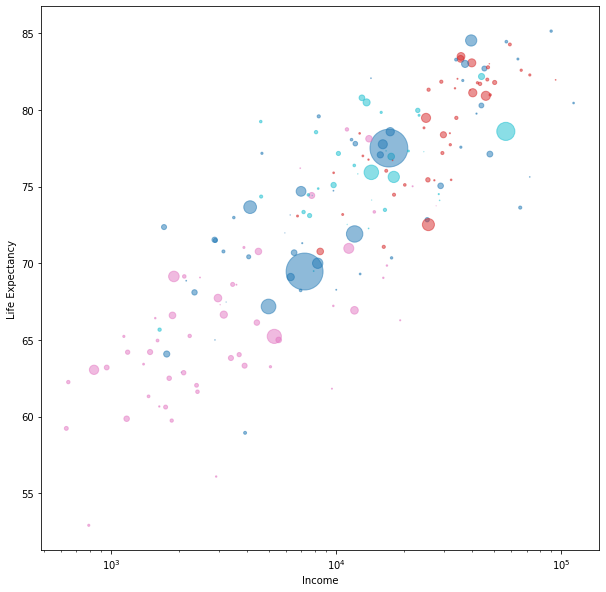

In [8]:
time_index = 2019
fig, ax = plt.subplots(figsize=(10, 10))
scat = ax.scatter('Income per person', 'Life expectancy', s="country_size", c='region_color', alpha = 0.5, data = life_exp_vs_income_pp[life_exp_vs_income_pp["time"] == time_index])
ax.set_ylabel('Life Expectancy')
ax.set_xlabel('Income')
ax.ticklabel_format(axis='y',style='sci')
plt.xscale("log")

In [9]:
def animate(i):
    i=i+1800
    next_vals = life_exp_vs_income_pp[life_exp_vs_income_pp["time"] == i]
    #ax.scatter('Income per person', 'Life expectancy', s="country_size", c='region_color', alpha = 0.5, data = life_exp_vs_income_pp[life_exp_vs_income_pp["time"] == time_index])
    scat.set_offsets(np.c_[next_vals['Income per person'], next_vals['Life expectancy']])
    scat.set_sizes(next_vals['country_size'])
    #print(next_vals['region_color'].values)
    #scat.set_array(next_vals['region_color'].values)
    time_text.set_text(i)
    return (scat,)

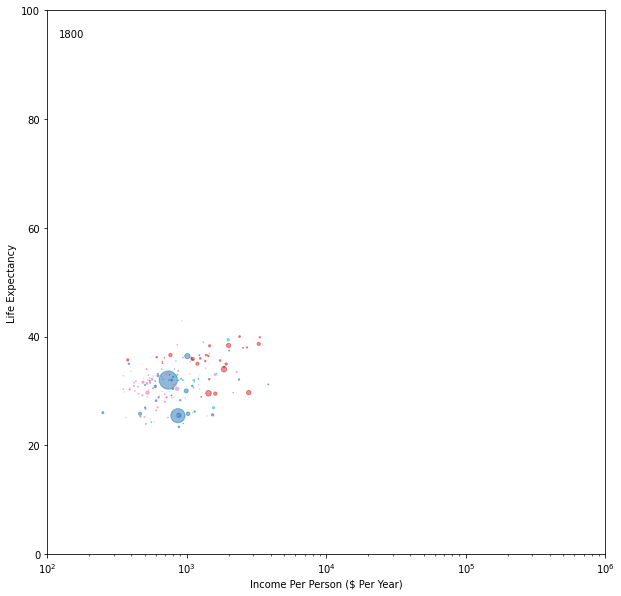

In [10]:
time_index = 1800
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(xlim=(10**2,10**6), ylim=(0,100))
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
time_text.set_text('Starting')
scat = ax.scatter('Income per person', 'Life expectancy', s="country_size", c='region_color', alpha = 0.5, data = life_exp_vs_income_pp[life_exp_vs_income_pp["time"] == time_index])
plt.xscale("log")
ax.set_ylabel('Life Expectancy')
ax.set_xlabel('Income Per Person ($ Per Year)')

anim = FuncAnimation(fig, animate, interval=150, 
                     frames=219,  blit=True)


plt.draw()
plt.show()




#HTML(anim.to_html5_video())
anim.save('gapminder.mp4')


## Playing with widgets to add interactivity

In [4]:
# defining some widgets
text = widgets.Text(
       value='My Text',
       description='Title', )
calendar = widgets.DatePicker(
           description='Select Date')
slider = widgets.FloatSlider(
         value=1,
         min=0,
         max=10.0,
         step=0.1,)
menu = widgets.Dropdown(
       options=['red', 'blue', 'green'],
       value='red',
       description='Color:')
checkbox = widgets.Checkbox(
    description='Check to invert',)

In [5]:
menu

Dropdown(description='Color:', options=('red', 'blue', 'green'), value='red')

In [6]:
box = widgets.VBox([text, slider, menu, calendar, checkbox])
box